# Getting started
ExplainableAI.jl can be used on any classifier.
In this first example, we will look at attributions on a LeNet5 model that was pretrained on MNIST.

### Loading the model

In [1]:
using ExplainableAI
using Flux
using BSON

model = BSON.load("../model.bson", @__MODULE__)[:model]

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

### Loading MNIST
We use MLDatasets to load a single image from the MNIST dataset:

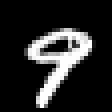

In [2]:
using MLDatasets
using ImageCore
using ImageIO
using ImageShow

index = 10
x, _ = MNIST(Float32, :test)[10]

convert2image(MNIST, x)

By convention in Flux.jl, this input needs to be resized to WHCN format by adding a color channel and batch dimensions.

In [3]:
input = reshape(x, 28, 28, 1, :);

## Calling the analyzer
We can now select an analyzer of our choice
and call `analyze` to get an `Explanation`:

In [4]:
analyzer = LRP(model)
expl = analyze(input, analyzer);

This `Explanation` bundles the following data:
* `expl.attribution`: the analyzer's attribution
* `expl.output`: the model output
* `expl.neuron_selection`: the neuron index used for the attribution
* `expl.analyzer`: a symbol corresponding the used analyzer, e.g. `:LRP`

Finally, we can visualize the `Explanation` through `heatmap`:

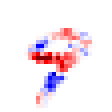

In [5]:
heatmap(expl)

Or get the same result by combining both analysis and heatmapping into one step:

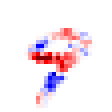

In [6]:
heatmap(input, analyzer)

## Neuron selection
By passing an additional index to our call to `analyze`, we can compute the attribution
with respect to a specific output neuron.
Let's see why the output wasn't interpreted as a 4 (output neuron at index 5)

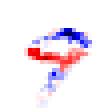

In [7]:
heatmap(input, analyzer, 5)

This heatmap shows us that the "upper loop" of the hand-drawn 9 has negative relevance
with respect to the output neuron corresponding to digit 4!

## Input batches
ExplainableAI also supports input batches:

In [8]:
batchsize = 100
xs, _ = MNIST(Float32, :test)[1:batchsize]
batch = reshape(xs, 28, 28, 1, :) # reshape to WHCN format
expl_batch = analyze(batch, analyzer);

This will once again return a single `Explanation` `expl_batch` for the entire batch.
Calling `heatmap` on `expl_batch` will detect the batch dimension and return a vector of heatmaps.

Let's check if the digit at `index = 10` still matches.

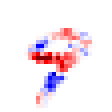

In [9]:
hs = heatmap(expl_batch)
hs[index]

JuliaImages' `mosaic` can be used to return a tiled view of all heatmaps:

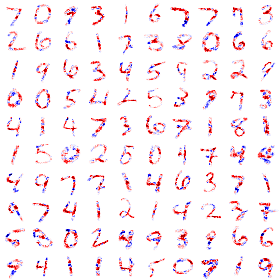

In [10]:
mosaic(hs; nrow=10)

We can also evaluate a batch with respect to a specific output neuron, e.g. for the digit zero at index `1`:

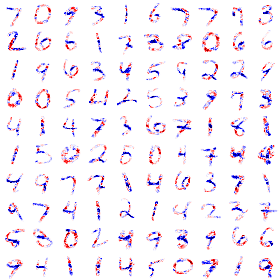

In [11]:
mosaic(heatmap(batch, analyzer, 1); nrow=10)

## Automatic heatmap presets
Currently, the following analyzers are implemented:

```
├── Gradient
├── InputTimesGradient
├── SmoothGrad
├── IntegratedGradients
└── LRP
    ├── ZeroRule
    ├── EpsilonRule
    ├── GammaRule
    ├── WSquareRule
    ├── FlatRule
    ├── ZBoxRule
    ├── ZPlusRule
    ├── AlphaBetaRule
    └── PassRule
```

Let's try `InputTimesGradient`

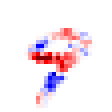

In [12]:
analyzer = InputTimesGradient(model)
heatmap(input, analyzer)

and `Gradient`

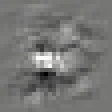

In [13]:
analyzer = Gradient(model)
heatmap(input, analyzer)

As you can see, the function `heatmap` automatically applies common presets for each method.

Since `InputTimesGradient` and `LRP` both compute attributions, their presets are similar.
Gradient methods however are typically shown in grayscale.

## Custom heatmap settings
We can partially or fully override presets by passing keyword arguments to `heatmap`:

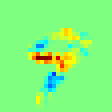

In [14]:
using ColorSchemes
heatmap(expl; cs=ColorSchemes.jet)

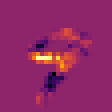

In [15]:
heatmap(expl; reduce=:sum, rangescale=:extrema, cs=ColorSchemes.inferno)

This also works with batches

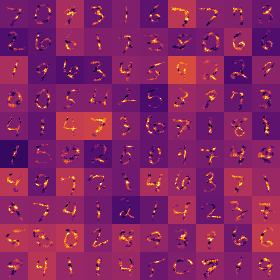

In [16]:
mosaic(heatmap(expl_batch; rangescale=:extrema, cs=ColorSchemes.inferno); nrow=10)

For the full list of keyword arguments, refer to the `heatmap` documentation.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*